In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random
from matplotlib import image
from sklearn.model_selection import train_test_split
import pickle
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
import json
from sklearn.metrics import confusion_matrix

In [28]:
import pandas as pd
from PIL import Image
import seaborn as sns
from ipywidgets import widgets
from pathlib import Path
from IPython.display import display
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout

In [29]:
def get_classes(dir_path):
    return os.listdir(dir_path)

def data_analysis_histogram(dir_path, classes, verbose = 1):
    class_dist = []
    for c in classes:
        class_path = os.path.join(dir_path,c)
        class_dist.append(len(os.listdir(class_path)))
    
    if verbose > 0:
        plt.figure(figsize=(16, 8))
        plt.title("Class distribution")
        plt.barh(classes, class_dist)
        for index, value in enumerate(class_dist):
            plt.text(value, index,str(value))
        plt.show()
    return class_dist

def data_analysis_image_size(dir_path, classes, verbose = 1, seed = 42):
    random.seed(seed)
    random_class_path = os.path.join(dir_path,random.choice(classes))
    random_img_name = random.choice(os.listdir(random_class_path))
    random_img_path = os.path.join(random_class_path,random_img_name)
    img = image.imread(random_img_path)
    if verbose > 0:
        plt.figure(figsize=(16, 8))
        plt.title("%s - Height: %d px x Length: %d px" % (random_img_path,img.shape[0],img.shape[1]))
        plt.imshow(img)
    
    return (img.shape[0],img.shape[1],1)

def analyse_dataset(dir_path, verbose = 1, seed = 42):
    classes = get_classes(dir_path)
    class_dist = data_analysis_histogram(dir_path,classes, verbose)
    input_shape = data_analysis_image_size(dir_path,classes, verbose, seed)
    return classes, input_shape, class_dist


In [30]:
def load_dataset(dir_path, percentage = 1, verbose = 1):
    classes = get_classes(dir_path)
    img_array = []
    class_array = []
    for c in classes:
        class_path = os.path.join(dir_path,c)
        imgs_name = os.listdir(class_path)

        if percentage < 1:
            imgs_name = random.sample(imgs_name, k = int(len(imgs_name)*percentage))

        for i in imgs_name:
            img_array.append(image.imread(os.path.join(class_path,i)))
            class_array.append(c)
    if verbose > 0:
        print("Loaded %d images" % len(img_array))
        
    return np.array(img_array), np.array(class_array)

In [31]:
def split_dataset(x, y, val_size = 0.2, verbose = 1, seed = 42):
    x_train, x_val, y_train, y_val = train_test_split(x,  y, test_size=val_size, random_state=seed)
    if verbose > 0:
        print("Train size: %d\nValidation size: %d" % (len(x_train), len(x_val)))
    return x_train, x_val, y_train, y_val

In [32]:
def prepare_dataset_channel_position(x, input_shape):
    img_lin,img_col,n_channels = input_shape
    if keras.backend.image_data_format() == 'channels_first':
        x = x.reshape(x.shape[0], n_channels, img_lin, img_col)
        input_shape = (n_channels, img_lin, img_col)
    else:
        x = x.reshape(x.shape[0], img_lin, img_col, n_channels)
        input_shape = (img_lin, img_col, n_channels)
    return x, input_shape

def prepare_dataset_input(x, input_shape):
    x_scaled = x.astype('float32') / 255.0
    return prepare_dataset_channel_position(x_scaled, input_shape)

def prepare_dataset_output(y, classes):
    class_map = {x: i for i,x in enumerate(classes)}
    y_code = [class_map[word] for word in y]
    y_categorical = keras.utils.to_categorical(y_code, len(classes))
    inv_class_map = {v: k for k, v in class_map.items()}
    return y_categorical, inv_class_map

def prepare_dataset(x , y , classes, input_shape):
    x_scaled, input_shape = prepare_dataset_input(x, input_shape)
    y_categorical, inv_class_map = prepare_dataset_output(y, classes)
    return x_scaled , y_categorical, inv_class_map, input_shape

In [55]:
def evaluate_model_by_class(model, x, y, verbose = 1):
    def separate_by_class(x, y):
        n_classes = y.shape[1]
        x_classified = [[] for _ in range(n_classes)]
        y_classified = [[] for _ in range(n_classes)]
        
        for i,img in enumerate(y):
            index = np.where(img==1)[0][0]
            x_classified[index].append(x[i])
            y_classified[index].append(y[i])

        for i in range(n_classes):
            x_classified[i] = np.array(x_classified[i])
            y_classified[i] = np.array(y_classified[i])
            
        return np.array(x_classified,dtype=object), np.array(y_classified,dtype=object)

    x_by_class, y_by_class = separate_by_class(x,y)
    
    score_by_class = []
    for i,(x,y) in enumerate(zip(x_by_class,y_by_class)):
        score = model.evaluate(x, y, verbose = verbose)
        score_by_class.append(score)

    return score_by_class

def evaluate_model_confusion_matrix(model, x, y, inv_class_map, verbose = 1):
    def undoOneHotEncoding(y, inv_class_map):
        return [inv_class_map[i] for i in np.argmax(y, axis = 1)]
    
    y_pred = model.predict(x)
    y_pred_int = undoOneHotEncoding(y_pred, inv_class_map)
    y_int = undoOneHotEncoding(y, inv_class_map)
    cm = confusion_matrix(y_int, y_pred_int)
    if verbose > 0:
        cm_df = pd.DataFrame(cm,
                            index = [inv_class_map[i] for i in range(len(inv_class_map))], 
                            columns = [inv_class_map[i] for i in range(len(inv_class_map))])
        plt.figure(figsize=(16,16))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
    return cm
	

def evaluate_model(model, x, y, inv_class_map, verbose = 1):
    score = model.evaluate(x, y, verbose = verbose)
    score_by_class = evaluate_model_by_class(model, x, y, verbose)
    cm = evaluate_model_confusion_matrix(model,x, y, inv_class_map, verbose)

    if verbose > 0:
        print()
        print("Global loss: %.4f" % (score))
        for i, s in enumerate(score_by_class):
            print("Class %s loss: %.4f" % (inv_class_map[i], s))

    all_scores = {
        'loss': score,
        'loss_by_class': score_by_class,
        'confusion': cm.tolist()
    }

    return all_scores

In [34]:
def plot_loss_history(history,verbose):
    if verbose > 0:
        plt.figure(figsize=(16, 8))
        plt.plot(history['loss'], label="Loss")
        plt.show()

In [35]:
def save_result(model, history, dir_path = 'results'):
    results_directory = os.path.join(dir_path)

    if not os.path.exists(results_directory):
        os.makedirs(results_directory)
    
    now = datetime.now()
    now_str = now.strftime("%Y-%m-%d-%H-%M-%S-%f")

    result_directory = os.path.join(results_directory,now_str)

    if not os.path.exists(result_directory):
        os.makedirs(result_directory)
    else:
        raise ValueError("File already exists.")
    
    model_path = os.path.join(result_directory,'model')
    model.save(model_path)

    evaluation_path = os.path.join(result_directory,'evaluation')

    evaluation = {
            'epochs': history.params['epochs'],
            'history': history.history
    }

    with open(evaluation_path, 'wb') as f:
        pickle.dump(evaluation, f)
    
    print("Saved!")
    return now_str

In [36]:
def load_result(foldername, dir_path = 'results'):
    result_directory = os.path.join(dir_path,foldername)
    if not os.path.exists(result_directory):
        raise ValueError("Folder not found.")
    
    model_path = os.path.join(result_directory,'model')
    model = keras.models.load_model(model_path)

    evaluation_path = os.path.join(result_directory,'evaluation')
    evaluation = pickle.load(open(evaluation_path, "rb"))
    
    return model, evaluation

In [37]:
def save_evaluation(foldername, name, all_scores, dir_path = 'results'):
    result_directory = os.path.join(dir_path,foldername)
    if not os.path.exists(result_directory):
        raise ValueError("Folder not found.")
    
    score_path = os.path.join(result_directory, name + '_score.json')
    with open(score_path, 'w') as f:
        json.dump(all_scores, f, ensure_ascii=False, indent=4)

###############################################################################################################################################################################################

In [38]:
def get_class_weight(classes, y):
    class_weight = compute_class_weight('balanced', classes,  y)
    return dict(zip(range(len(classes)),class_weight))

In [41]:
def run_cnn(x, y, input_shape, classes, class_weight, verbose = 1):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1),  padding='same', activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(len(classes), activation='softmax'))

    if verbose > 0:
        model.summary()

    model.compile(loss='categorical_crossentropy',
              optimizer='adam')

    history = model.fit(x, y,
                    batch_size=128,
                    epochs=100, class_weight = class_weight, verbose=verbose)

    return model, history

###############################################################################################################################################################################################

In [71]:
#foldername = 'classweight_five_more_layers_2_dropout_layers'
#model, evaluation = load_result(foldername)
#history = evaluation['history']

###############################################################################################################################################################################################

In [43]:
# Parameters
dir_path = '../Alzheimer_s Dataset/train'
verbose_loading = 0
verbose_training = 1
verbose_evaluating = 1
dataset_percentage = 1
validation_percentage = 0.2
seed = 42

In [44]:
# Loading and preparing training dataset
classes, input_shape, class_dist = analyse_dataset(dir_path, verbose_loading, seed)
x, y = load_dataset(dir_path, dataset_percentage , verbose_loading)
x_train, x_val, y_train, y_val = split_dataset(x, y, validation_percentage, verbose_loading, seed)
x_train_prepared , y_train_prepared, inv_class_map, input_shape = prepare_dataset(x_train , y_train , classes, input_shape)
x_val_prepared , y_val_prepared, _, _ = prepare_dataset(x_val , y_val , classes, input_shape)

In [45]:
class_weight = get_class_weight(classes, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], y=['NonDemented' 'VeryMildDemented' 'VeryMildDemented' ... 'NonDemented'
 'VeryMildDemented' 'NonDemented'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [57]:
# Executing
model, history = run_cnn(input_shape, classes, class_weight, verbose_training)
foldername = save_result(model, history)
history = history.history

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 208, 176, 64)      640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 104, 88, 64)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 104, 88, 64)       36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 52, 44, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 26, 22, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 22, 64)       

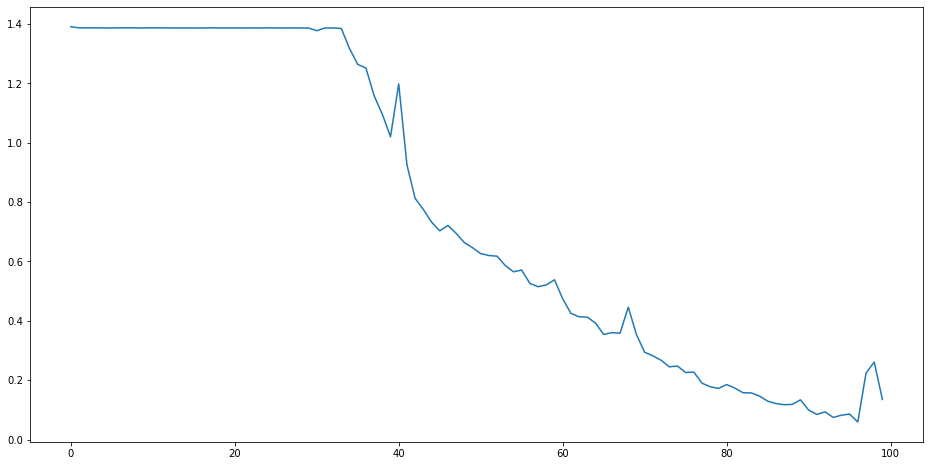


Training
46/46 [==============================] - 9s 188ms/step - loss: 0.0945


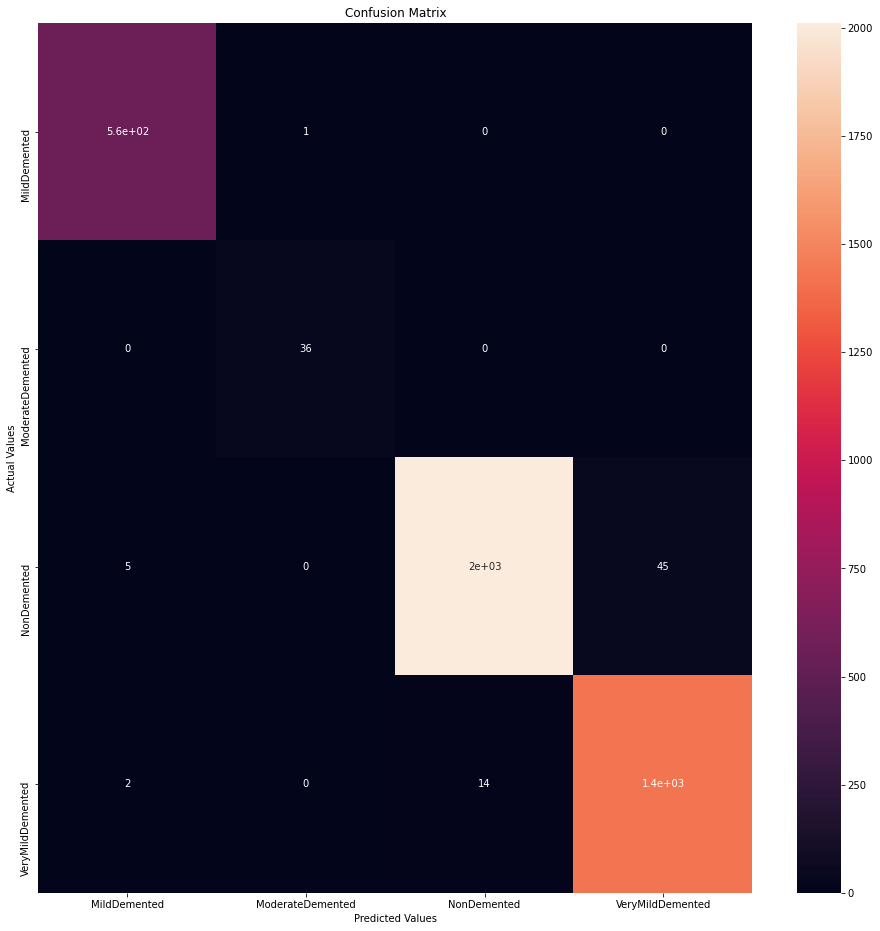


Global loss: 0.0776
Class MildDemented loss: 0.0154
Class ModerateDemented loss: 0.0000
Class NonDemented loss: 0.0840
Class VeryMildDemented loss: 0.0945

Validation
11/11 [==============================] - 2s 190ms/step - loss: 0.2026


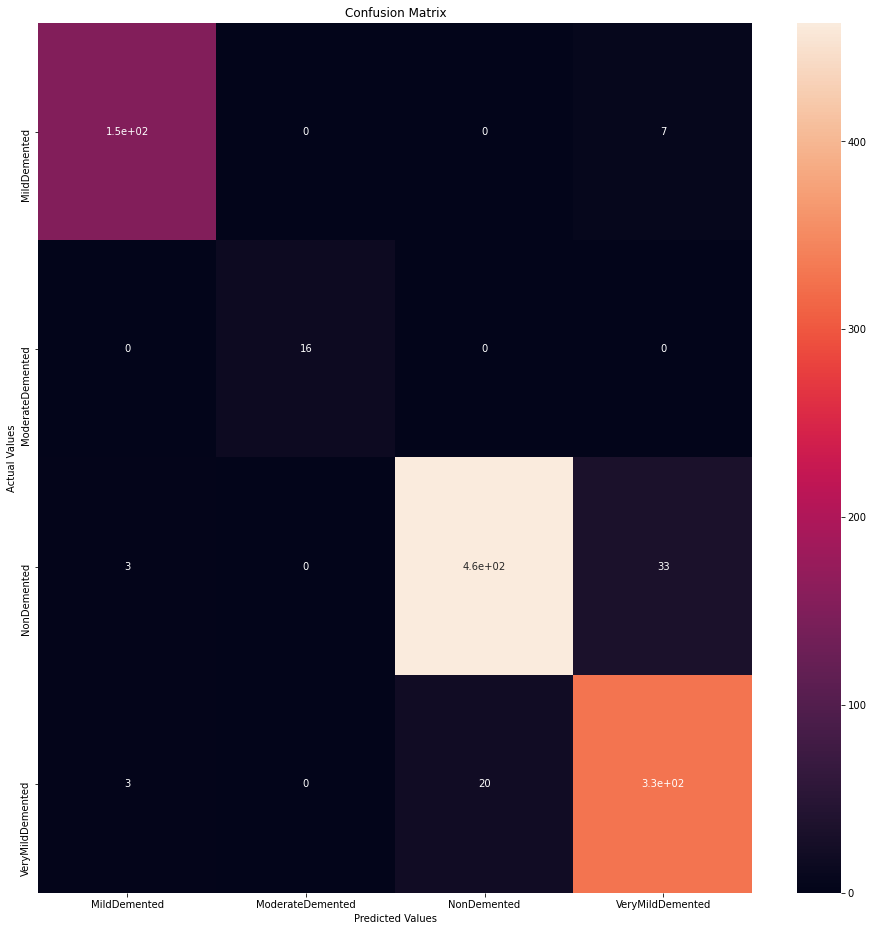


Global loss: 0.1823
Class MildDemented loss: 0.1914
Class ModerateDemented loss: 0.0017
Class NonDemented loss: 0.1710
Class VeryMildDemented loss: 0.2026


In [72]:
# Evaluating CNN
plot_loss_history(history,verbose_evaluating)
print("\nTraining")
train_score = evaluate_model(model, x_train_prepared, y_train_prepared, inv_class_map, verbose_evaluating)
print("\nValidation")
val_score = evaluate_model(model, x_val_prepared, y_val_prepared, inv_class_map, verbose_evaluating)
save_evaluation(foldername,'training', train_score)
save_evaluation(foldername,'validation', val_score)